In [1]:
# Load the dataset and some utility functions
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

import torch
import torch.utils.data as utils
import torch.nn.functional as F
import torch.optim as optim
from pyro.distributions.torch import Normal
from pyro.distributions.torch import Categorical

# If GPU is available set it to a GPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import numpy as np
import pyro
import matplotlib.pyplot as plt

In [2]:
# Load the iris dataset
data = load_iris()
X = data['data']
Y = data['target']

X = scale(X, axis=0)
print(X,Y)
print(X.shape,Y.shape)

# Scale all data with 0 mean and unit standard deviation
for i in range(X.shape[1]):
    print(X[:,i].mean(),X[:,i].std())

[[-9.00681170e-01  1.01900435e+00 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00 -1.31979479e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.38535265e+00  3.28414053e-01 -1.39706395e+00 -1.31544430e+00]
 [-1.50652052e+00  9.82172869e-02 -1.28338910e+00 -1.31544430e+00]
 [-1.02184904e+00  1.24920112e+00 -1.34022653e+00 -1.31544430e+00]
 [-5.37177559e-01  1.93979142e+00 -1.16971425e+00 -1.05217993e+00]
 [-1.50652052e+00  7.88807586e-01 -1.34022653e+00 -1.18381211e+00]
 [-1.02184904e+00  7.88807586e-01 -1.28338910e+00 -1.31544430e+00]
 [-1.74885626e+00 -3.62176246e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00  9.82172869e-02 -1.28338910e+00 -1.44707648e+00]
 [-5.37177559e-01  1.47939788e+00 -1.28338910e+00 -1.31544430e+00]
 [-1.26418478e+00  7.88807586e-01 -1.22655167e+00 -1.31544430e+00]
 [-1.26418478e+00 -1.31979479e-01 -1.34022653e+00 -1.44707648e+00]
 [-1.87002413e+00 -1.31979479e-01 -1.51073881e+00 -1.44707648e+00]
 [-5.25060772e-02  2.16998818e+00 -1.45390138e+00 -1.31544430e

In [3]:
# Split the dataset into training, test, validation
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(96, 4) (24, 4) (30, 4)
(96,) (24,) (30,)


In [4]:
# Create loaders for trainining, test, validation, set the batch size to 8
def create_loader(x,y,batch_size = 8):
    tensor_x = torch.stack([torch.Tensor(i) for i in x]) 
    tensor_y = torch.stack([torch.tensor(np.array(i), dtype=torch.long) for i in y])
    dataset = utils.TensorDataset(tensor_x,tensor_y)
    return dataset, utils.DataLoader(dataset,batch_size = batch_size) 

train_dataset, train_loader = create_loader(X_train,y_train)
val_dataset, val_loader = create_loader(X_val,y_val)
test_dataset, test_loader = create_loader(X_test,y_test)

In [5]:
# Define a very simple model consisting of 4 inputs, 10 input nodes and 4 output nodes
class FCNet(torch.nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.input = torch.nn.Linear(4, 10)
        self.output = torch.nn.Linear(10,4)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        return self.output(x)
    
net = FCNet()
net.to(DEVICE)

FCNet(
  (input): Linear(in_features=4, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=4, bias=True)
)

In [6]:
# Define the PRIORS for the model that we have just defined
def model(x_data, y_data):
    # Define normal priors for INPUT layer
    inputw_prior = Normal(loc=torch.zeros_like(net.input.weight), scale=torch.ones_like(net.input.weight))
    inputb_prior = Normal(loc=torch.zeros_like(net.input.bias), scale=torch.ones_like(net.input.bias))
    
    # Define normal priors for OUTPUT layer
    outputw_prior = Normal(loc=torch.zeros_like(net.output.weight), scale=torch.ones_like(net.output.weight))
    outputb_prior = Normal(loc=torch.zeros_like(net.output.bias), scale=torch.ones_like(net.output.bias))
    
    # 
    priors = {'input.weight': inputw_prior, 'input.bias': inputb_prior,  'output.weight': outputw_prior, 'output.bias': outputb_prior}
    
    # Lift module parameters to 
    # random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    
    # Sample a regressor to sample w and b
    lifted_reg_model = lifted_module()
    
    # Pyro does not have an automatic activation depending on loss and given
    # That we want to do classification we need to use log softmax
    lhat = F.log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [7]:
# This function is going to represent the POSTERIOR
# that we have just defined and which we are going try
# and approximate to the true posterior
def guide(x_data, y_data):
    # First layer weight distribution priors
    inputw_mu = torch.randn_like(net.input.weight)
    inputw_sigma = torch.randn_like(net.input.weight)
    inputw_mu_param = pyro.param("inputw_mu", inputw_mu)
    inputw_sigma_param = F.softplus(pyro.param("inputw_sigma", inputw_sigma))
    inputw_prior = Normal(loc=inputw_mu_param, scale=inputw_sigma_param)
    
    # First layer bias distribution priors
    inputb_mu = torch.randn_like(net.input.bias)
    inputb_sigma = torch.randn_like(net.input.bias)
    inputb_mu_param = pyro.param("inputb_mu", inputb_mu)
    inputb_sigma_param = F.softplus(pyro.param("inputb_sigma", inputb_sigma))
    inputb_prior = Normal(loc=inputb_mu_param, scale=inputb_sigma_param)
    
    # Output layer weight distribution priors
    outputw_mu = torch.randn_like(net.output.weight)
    outputw_sigma = torch.randn_like(net.output.weight)
    outputw_mu_param = pyro.param("outputw_mu", outputw_mu)
    outputw_sigma_param = F.softplus(pyro.param("outputw_sigma", outputw_sigma))
    outputw_prior = Normal(loc=outputw_mu_param, scale=outputw_sigma_param).independent(1)
    
    # Output layer bias distribution priors
    outputb_mu = torch.randn_like(net.output.bias)
    outputb_sigma = torch.randn_like(net.output.bias)
    outputb_mu_param = pyro.param("outputb_mu", outputb_mu)
    outputb_sigma_param = F.softplus(pyro.param("outputb_sigma", outputb_sigma))
    outputb_prior = Normal(loc=outputb_mu_param, scale=outputb_sigma_param)
    
    priors = {'input.weight': inputw_prior, 'input.bias': inputb_prior, 'output.weight': outputw_prior, 'output.bias': outputb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [8]:
# Define an optimiser in this case ADAM and we are going to use the double stochastic VI and maximise the ELBO
optim = pyro.optim.Adam({"lr": 0.1})
svi = pyro.infer.svi.SVI(model, guide, optim, loss=pyro.infer.trace_elbo.Trace_ELBO())

In [9]:
# Since Bayesian NN functions thanks to sampling the models
# we need to sample the model several times to get several different estimates
# for the input data x 
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    std = torch.std(torch.stack(yhats), 0).numpy()
    mean = np.argmax(mean.numpy(), axis=1)
    std = np.array([std[i,mean[i]] for i in range(len(mean))])
    return mean, std

In [10]:
# Just a utility function to calculate the accuracy
def accuracy(out, labels):
    return np.sum(out==labels)/float(labels.size)

In [11]:
EPOCHS = 5

train_loss = []
val_loss = []

train_acc = []
val_acc = []

train_std = []
val_std = []

with torch.no_grad():
    t,t_std = predict(train_dataset.tensors[0])
    v,v_std = predict(val_dataset.tensors[0])
    t_loss = svi.evaluate_loss(train_dataset.tensors[0].to(DEVICE), train_dataset.tensors[1].to(DEVICE))
    v_loss = svi.evaluate_loss(val_dataset.tensors[0].to(DEVICE), val_dataset.tensors[1].to(DEVICE))
    train_loss.append(t_loss)
    val_loss.append(v_loss)
    train_acc.append(accuracy(t,train_dataset.tensors[1].numpy()))
    val_acc.append(accuracy(v,val_dataset.tensors[1].numpy()))
    train_std.append(np.mean(t_std))
    val_std.append(np.mean(v_std))
    print("Training accuracy: {0:.2f}".format(train_acc[-1]))
    print("Validation accuracy: {0:.2f}".format(val_acc[-1]))

    # The main training loop
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

        loss = svi.step(inputs, labels)

        running_loss += loss
        if i % 5 == 4:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0
            
    with torch.no_grad():
        t,t_std = predict(train_dataset.tensors[0].to(DEVICE))
        v,v_std = predict(val_dataset.tensors[0].to(DEVICE))
        t_loss = svi.evaluate_loss(train_dataset.tensors[0].to(DEVICE), train_dataset.tensors[1].to(DEVICE))
        v_loss = svi.evaluate_loss(val_dataset.tensors[0].to(DEVICE), val_dataset.tensors[1].to(DEVICE))
        train_loss.append(t_loss)
        val_loss.append(v_loss)
        train_acc.append(accuracy(t,train_dataset.tensors[1].numpy()))
        val_acc.append(accuracy(v,val_dataset.tensors[1].numpy()))
        train_std.append(t_std.mean())
        val_std.append(v_std.mean())
        print("Training accuracy: {0:.2f}".format(train_acc[-1]))
        print("Validation accuracy: {0:.2f}".format(val_acc[-1]))
        
print('Finished Training')
with torch.no_grad():
    t,t_std = predict(test_dataset.tensors[0])
    print("Test accuracy: {0:.2f}".format(accuracy(t,test_dataset.tensors[1].numpy())))


Training accuracy: 0.34
Validation accuracy: 0.42
[1,     5] loss: 117.013
[1,    10] loss: 90.118
Training accuracy: 0.71
Validation accuracy: 0.79
[2,     5] loss: 50.260
[2,    10] loss: 39.829


/Users/martinferianc/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training accuracy: 0.68
Validation accuracy: 0.75
[3,     5] loss: 36.052
[3,    10] loss: 43.252
Training accuracy: 0.68
Validation accuracy: 0.75
[4,     5] loss: 37.936
[4,    10] loss: 34.851
Training accuracy: 0.77
Validation accuracy: 0.92
[5,     5] loss: 37.815
[5,    10] loss: 32.304
Training accuracy: 0.67
Validation accuracy: 0.67
Finished Training
Test accuracy: 0.57


[6.724348, 6.1240406, 5.3167567, 5.109192, 4.3771906, 3.8800323] [7.463548, 4.7818184, 5.0435147, 6.689703, 4.310799, 4.3425584]


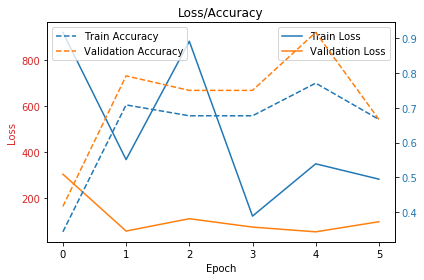

In [12]:
# Plot the loss, accuracy as well as the standard deviation
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel("Epoch")
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_loss,label="Train Loss")
ax1.plot(val_loss,label="Validation Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(train_acc,linestyle='dashed',label="Train Accuracy")
ax2.plot(val_acc,linestyle='dashed',label="Validation Accuracy")
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend()

plt.title("Loss/Accuracy")
fig.tight_layout()

print(train_std,val_std)